In [2]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import networkx as nx
import pycombo

In [ ]:
! python -m pip install https://github.com/Casyfill/pyCombo/archive/master.tar.gz#egg=pycombo

## Karate Club

Unweighted non-directed graph

In [5]:
G = nx.karate_club_graph()

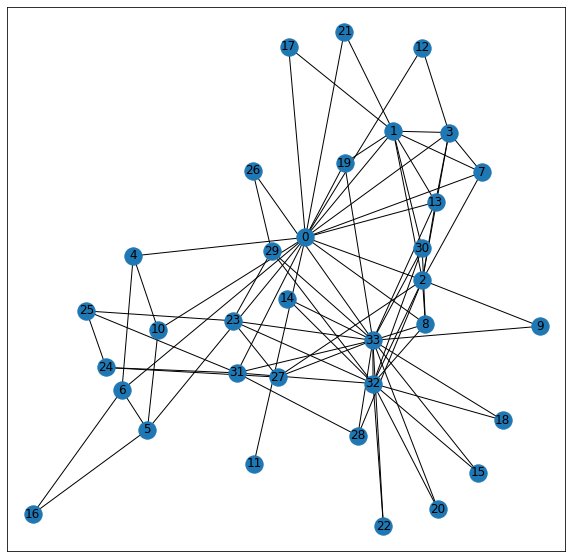

In [9]:
fig, ax =  plt.subplots(figsize=(10,10))

pos=nx.spring_layout(G)
nx.draw_networkx(G,pos, ax=ax)

In [14]:
partition, modularity = pycombo.execute(G, return_modularity=True)

AttributeError: module 'pycombo' has no attribute 'execute'

Visualise

Execute from adjacency matrix

Execute from file